<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="https://www.uoc.edu/portal/_resources/common/imatges/sala_de_premsa/noticies/2016/202-nova-marca-uoc.jpg", align="left" width="380" height="120">

</div>
</div>
<div style="float: right; width: 50%;">
<p>&nbsp;</p>
<p style="margin: 0; padding-top: 22px; text-align:right;">&nbsp;&nbsp;&nbsp;&nbsp;Máster en Ciencia de Datos</p>
<p style="margin: 0; text-align:right;">&nbsp;&nbsp;&nbsp;&nbsp;Área 2: Machine Learning in Cybersecurity</p>
<p>&nbsp;</p>
</div>
</div>
<div style="width: 100%; clear: both;">
<div style="width:100%;">&nbsp;</div>

<p><b>Desafíos y optimización en sistemas de detección de intrusiones (IDS) basados en comportamiento</b></p>
<p><i><b>Autor: </b>Ivan Benaiges Trenchs</i></p>
<p><i><b>Tutor/a de TF: </b>Blas Torregrosa Garcia</i></p>
<p><i><b>Profesor/a responsable de la asignatura: </b>JosepAnton Mir Tutusaus</i></p>

# Modelo incremental basado en destilación de conocimiento y buffer de memoria

Durante el transcurso de este notebook se ha desarrollado y evaluado un modelo incremental que combina técnicas avanzadas de aprendizaje continuo, basado en la destilación de conocimiento y el uso de un buffer de memoria que permiten mantener el conocimiento anteriormente obtenido para tratar de evitar el olvido catastrófico.

Este enfoque se basa en actualizar un único modelo a lo largo del tiempo, incorporando nuevos datos de forma diaria mientras se preserva el conocimiento previo. A diferencia de los otros enfoques, este modelo no se reentrena desde cero, sino que utiliza estrategias específicas para evitar la pérdida de conocimiento histórico y adaptarse dinámicamente a nuevos patrones.

El gran handicap de este enfoque recae en la facilidad con la que se puede dar un olvido catastrófico que pueda dar pie a un modelo ineficiente y poco útil. No obstante, sigue ofreciendo ventajas notables frente a enfoques más clásicos que utilizan modelos estáticos, aunque se reentrenen.

## Paso 1: Importar librerías

In [ ]:
# Importamos las librerías a utilizar a lo largo de este Notebook:
import tensorflow as tf
import platform
import psutil
import os
import time
import random
from google.colab import drive
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import Mean
from tensorflow.keras.losses import CategoricalCrossentropy, KLDivergence
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback
from tensorflow.keras.layers import Input, Dense, Conv1D, MaxPooling1D, LSTM, Dropout, Flatten, BatchNormalization
from imblearn.over_sampling import RandomOverSampler, ADASYN
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from tensorflow.keras.models import load_model
from collections import defaultdict
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.utils import register_keras_serializable

## Paso 2: Obtener información del entorno de ejecución

Para llevar a cabo este proyecto se ha usado el entorno Google Colab configurado par ausar CPU con alta capacidad de RAM.

In [ ]:
# Información de TensorFlow y Python:
print(f"TensorFlow version: {tf.__version__}")
print(f"Python version: {platform.python_version()}")

# Información de GPU (aunque finalmente no se vaya a utilizar):
gpu_info = os.popen("nvidia-smi --query-gpu=gpu_name,memory.total --format=csv").read()
print("GPU Info:\n", gpu_info)

# Información de CPU:
cpu_info = os.popen("lscpu").read()
print("CPU Info:\n", cpu_info)

# Información de RAM:
ram = psutil.virtual_memory()
print(f"RAM Total: {ram.total / 1e9:.2f} GB")

TensorFlow version: 2.17.1
Python version: 3.10.12
GPU Info:
 
CPU Info:
 Architecture:                         x86_64
CPU op-mode(s):                       32-bit, 64-bit
Address sizes:                        48 bits physical, 48 bits virtual
Byte Order:                           Little Endian
CPU(s):                               8
On-line CPU(s) list:                  0-7
Vendor ID:                            AuthenticAMD
Model name:                           AMD EPYC 7B12
CPU family:                           23
Model:                                49
Thread(s) per core:                   2
Core(s) per socket:                   4
Socket(s):                            1
Stepping:                             0
BogoMIPS:                             4499.99
Flags:                                fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ht syscall nx mmxext fxsr_opt pdpe1gb rdtscp lm constant_tsc rep_good nopl nonstop_tsc cpuid ex

## Paso 3: Definiciones previas a la creación del modelo

In [ ]:
# Cargaremos los ficheros que conforman el dataset des de nuestro Google Drive:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Definimos la ruta de la carpeta donde están los ficheros CSV con los conjuntos de datos combinados:
dataset_folder = "/content/drive/My Drive/TFM - DS/output_datasets/"

# Obtenemos la lista de ficheros CSV que hay en la carpeta:
csv_files = [f for f in os.listdir(dataset_folder) if f.endswith('.csv')]
print(csv_files)

['02-14-2018_train.csv', '02-14-2018_val.csv', '02-14-2018_test.csv', '02-15-2018_val.csv', '02-15-2018_train.csv', '02-15-2018_test.csv', '02-16-2018_train.csv', '02-16-2018_val.csv', '02-16-2018_test.csv', '02-20-2018_train.csv', '02-20-2018_val.csv', '02-20-2018_test.csv', '02-21-2018_train.csv', '02-21-2018_test.csv', '02-21-2018_val.csv', '02-23-2018_train.csv', '02-23-2018_val.csv', '02-22-2018_test.csv', '02-22-2018_train.csv', '02-22-2018_val.csv', '02-23-2018_test.csv', '02-28-2018_test.csv', '02-28-2018_val.csv', '02-28-2018_train.csv', '03-01-2018_test.csv', '03-01-2018_val.csv', '03-01-2018_train.csv', '03-02-2018_train.csv', '03-02-2018_test.csv', '03-02-2018_val.csv', 'evaluation_results.csv']


In [ ]:
# Generamos la ruta donde guardaremos los resultados:
save_dir = os.path.join(dataset_folder, 'incremental_learning_kdmb_model')
os.makedirs(save_dir, exist_ok=True)

In [ ]:
# Generamos variables para poder gestionar mejor los conjuntos de entrenamiento, validación y test:
train_files = sorted([f for f in os.listdir(dataset_folder) if f.endswith('_train.csv')])
val_files = sorted([f for f in os.listdir(dataset_folder) if f.endswith('_val.csv')])
test_files = sorted([f for f in os.listdir(dataset_folder) if f.endswith('_test.csv')])

print("Archivos de entrenamiento:", train_files)
print("Archivos de validación:", val_files)
print("Archivos de prueba:", test_files)

# Verificamos que el número de archivos coincida y no haya ningún problema:
if not (len(train_files) == len(val_files) == len(test_files)):
    raise ValueError("El número de archivos de entrenamiento, validación y prueba no coincide.")

# Comprobamos el número total de días:
num_days = len(train_files)
print(f"Total de días en el dataset: {num_days} días")

Archivos de entrenamiento: ['02-14-2018_train.csv', '02-15-2018_train.csv', '02-16-2018_train.csv', '02-20-2018_train.csv', '02-21-2018_train.csv', '02-22-2018_train.csv', '02-23-2018_train.csv', '02-28-2018_train.csv', '03-01-2018_train.csv', '03-02-2018_train.csv']
Archivos de validación: ['02-14-2018_val.csv', '02-15-2018_val.csv', '02-16-2018_val.csv', '02-20-2018_val.csv', '02-21-2018_val.csv', '02-22-2018_val.csv', '02-23-2018_val.csv', '02-28-2018_val.csv', '03-01-2018_val.csv', '03-02-2018_val.csv']
Archivos de prueba: ['02-14-2018_test.csv', '02-15-2018_test.csv', '02-16-2018_test.csv', '02-20-2018_test.csv', '02-21-2018_test.csv', '02-22-2018_test.csv', '02-23-2018_test.csv', '02-28-2018_test.csv', '03-01-2018_test.csv', '03-02-2018_test.csv']
Total de días en el dataset: 10 días


In [ ]:
# Comprobamos que la información de los ficheros de los diferentes días es correcta:
for day in range(len(train_files)):
    train_file = os.path.join(dataset_folder, train_files[day])
    train_df = pd.read_csv(train_file)
    class_counts = train_df['Label'].value_counts()
    print(f"Día {day + 1} - Distribución de Clases:\n{class_counts}\n")

Día 1 - Distribución de Clases:
Label
Malicious    266660
Benign       266660
Name: count, dtype: int64

Día 2 - Distribución de Clases:
Label
Benign       36748
Malicious    36748
Name: count, dtype: int64

Día 3 - Distribución de Clases:
Label
Benign       312740
Malicious    312740
Name: count, dtype: int64

Día 4 - Distribución de Clases:
Label
Benign       403333
Malicious    403333
Name: count, dtype: int64

Día 5 - Distribución de Clases:
Label
Benign       252583
Malicious    252583
Name: count, dtype: int64

Día 6 - Distribución de Clases:
Label
Benign       253
Malicious    253
Name: count, dtype: int64

Día 7 - Distribución de Clases:
Label
Malicious    396
Benign       396
Name: count, dtype: int64

Día 8 - Distribución de Clases:
Label
Benign       47765
Malicious    47765
Name: count, dtype: int64

Día 9 - Distribución de Clases:
Label
Malicious    64682
Benign       64682
Name: count, dtype: int64

Día 10 - Distribución de Clases:
Label
Malicious    200333
Benign       2

In [ ]:
# Definimos las semillas para poder obtener resultados reproducibles:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

## Paso 4: Ajuste global del escalado y de las etiquetas

Debido a la gran cantidad de datos diferentes entre los días que conforman el dataset completo y para evitar problemas al tener escalados diferentes según el día y tipo de ataque, se ha decidido, debido a tratarse de un trabajo de investigación y prueba de diferentes modelos y enfoques, preparar un objeto que realice el escalado basado en el conjunto total de los datos.

No obstante, este punto podría haberse obviado para para analizar lo que esto conllevaría en un modelo real que estuviera en producción como, por ejemplo, el clasificar incorrectamente algunas muestras debido a un escalado que no tuviera en cuenta el conjunto global de los datos.

Por otro lado, pensando en un futuro trabajo basado en un modelo multiclase, se mantiene también la caracterización de las etiquetas a nivel global. Nuevamente, esto podría ser contraproducente para demostrar las carencias de este enfoque estático.

In [ ]:
# Ajustamos el MinMaxScaler globalmente con todos los datos de entrenamiento:
print("\nAjustando el MinMaxScaler globalmente con todos los datos de entrenamiento...")
all_train_X = []

for train_file in train_files:
    train_path = os.path.join(dataset_folder, train_file)
    train_df = pd.read_csv(train_path)
    X_train_day = train_df.drop(columns=['Label']).values
    all_train_X.append(X_train_day)

# Concatenamos todos los datos de entrenamiento:
all_train_X = np.vstack(all_train_X)
print(f"Forma de todos los datos de entrenamiento concatenados: {all_train_X.shape}")

# Inicializamos y ajustamos el scaler:
scaler = MinMaxScaler()
scaler.fit(all_train_X)
print("MinMaxScaler ajustado globalmente.")


Ajustando el MinMaxScaler globalmente con todos los datos de entrenamiento...
Forma de todos los datos de entrenamiento concatenados: (3170986, 78)
MinMaxScaler ajustado globalmente.


In [ ]:
# Inicializamos y ajustamos el LabelEncoder con todas las clases. Debido a que las clases son conocidas y fijas ajustamos solo una vez:
print("\nAjustando el LabelEncoder con todas las clases posibles...")
all_classes = set()
for train_file in train_files:
    train_path = os.path.join(dataset_folder, train_file)
    train_df = pd.read_csv(train_path)
    all_classes.update(train_df['Label'].unique())

label_encoder = LabelEncoder()
label_encoder.fit(list(all_classes))
print(f"Clases encontradas: {label_encoder.classes_}")


Ajustando el LabelEncoder con todas las clases posibles...
Clases encontradas: ['Benign' 'Malicious']


In [ ]:
# Definimos una función para verificar incongruencias entre las etiquetas:
def verify_labels(y, label_encoder, dataset_name=""):
    unknown_labels = set(y) - set(label_encoder.classes_)
    if unknown_labels:
        raise ValueError(f"Etiquetas desconocidas encontradas en {dataset_name}: {unknown_labels}")

Aunque finalmente no se ha utilizado en la creación de este modelo, se han realizado pruebas de data augmentation para tratar de mejorar los resultados y se ha mantenido el código en este punto por si en un futuro se puede mejorar el modelo gracias a esta técnica.

In [ ]:
# Identificamos los días que tienen un número menor de muestras que el valor definido en alguna clase:
threshold = 0

print(f"\nIdentificando días minoritarios (menos de {threshold} muestras por clase)...")
counts = pd.DataFrame()

# Esta comprobación se hace por fichero y por cada clase (de cara a un futuro incluir modelo multiclase):
for train_file in train_files:
    train_path = os.path.join(dataset_folder, train_file)
    train_df = pd.read_csv(train_path)
    day = train_file.split('_train.csv')[0]
    class_counts = train_df['Label'].value_counts()
    class_counts.name = day
    counts = pd.concat([counts, class_counts], axis=1)

counts = counts.fillna(0).T

# Identificamos los días que tienen al menos una clase con menos muestras que las definidas:
minority_days = counts[(counts < threshold).any(axis=1)].index.tolist()

print(f"Días minoritarios: {minority_days}")


Identificando días minoritarios (menos de 0 muestras por clase)...
Días minoritarios: []


## Paso 5: Creación del modelo

En este modelo se reutilizará la arquitectura híbrida CNN-LSTM vista en el resto de modelos, adaptándola a un enfoque incremental basado en destilación de conocimiento y buffer de memoria.

Este notebook busca evaluar los puntos fuertes y débiles de este enfoque respecto al modelo estático y al modelo basado en ventanas deslizantes.

In [ ]:
# Definimos el modelo en base al modelo estático:
def build_model(input_shape, num_classes=2):
    # 1. Capa de entrada:
    model = Sequential(name='cnn_lstm_incremental')
    model.add(Input(shape=input_shape, name='input'))

    # 2. Capas convolucionales con maxpooling y batch normalization:
    model.add(Dense(8, activation='relu', kernel_regularizer=l2(1e-3), name='dense_1'))
    model.add(Conv1D(8, kernel_size=3, activation='relu', padding='same', kernel_regularizer=l2(1e-3), name='conv1d_1'))
    model.add(Conv1D(16, kernel_size=3, activation='relu', kernel_regularizer=l2(1e-3), name='conv1d_2'))
    model.add(MaxPooling1D(pool_size=2, name='maxpool_1'))
    model.add(Conv1D(16, kernel_size=3, activation='relu', kernel_regularizer=l2(1e-3), name='conv1d_3'))
    model.add(Conv1D(32, kernel_size=3, activation='relu', kernel_regularizer=l2(1e-3), name='conv1d_4'))
    model.add(MaxPooling1D(pool_size=2, name='maxpool_2'))
    model.add(BatchNormalization(name='batchnorm_1'))

    # 3. Capa LSTM:
    model.add(LSTM(50, return_sequences=False, kernel_regularizer=l2(1e-3), name='lstm'))

    # 4. Capas densas completamente conectadas:
    model.add(Dense(32, activation='relu', kernel_regularizer=l2(1e-3), name='dense_2'))
    model.add(Dense(32, activation='relu', kernel_regularizer=l2(1e-3), name='dense_3'))
    model.add(Dense(32, activation='relu', kernel_regularizer=l2(1e-3), name='dense_4'))
    model.add(Dropout(0.3, name='dropout_1'))

    # Capa de salida con softmax (simulando la salida binaria en el caso que nos ocupa, aunque adaptable a una salida multiclase):
    model.add(Dense(num_classes, activation='softmax', kernel_regularizer=l2(1e-3), name='output'))

    return model

## Paso 6: Creación de un checkpoint de entrenamiento personalizado

Debido a que el uso de destilación de conocimiento genera unas métricas diferentes, hay que adaptar el checkpoint para guardar los resultados del mejor modelo. En este caso, vamos a adaptarlo para que no solo se centre en la pérdida de la validación, sino también en la exactitud en caso de dos valores de pérdida iguales.

Esto permitirá tener siempre el mejor modelo guardado para usarlo en la siguiente iteración del entrenamiento.

In [ ]:
# Definimos un callback para el checkpoint personalizado para guardar el mejor modelo basado en pérdida y exactitud:
class CustomModelCheckpoint(Callback):
    def __init__(self, filepath, monitor_loss='val_loss', monitor_acc='val_accuracy',
                 verbose=1, save_best_only=True, mode_loss='min', mode_acc='max'):
        super(CustomModelCheckpoint, self).__init__()
        self.filepath = filepath
        self.monitor_loss = monitor_loss
        self.monitor_acc = monitor_acc
        self.verbose = verbose
        self.save_best_only = save_best_only
        self.mode_loss = mode_loss
        self.mode_acc = mode_acc

        # Inicializamos los mejores valores según el modo definido:
        if self.mode_loss == 'min':
            self.best_loss = np.Inf
        else:
            self.best_loss = -np.Inf

        if self.mode_acc == 'max':
            self.best_acc = -np.Inf
        else:
            self.best_acc = np.Inf

    # Cada vez que una época termine se verifican los resultados obtenidos para discernir si es necesario guardar el modelo obtenido o no:
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        current_loss = logs.get(self.monitor_loss)
        current_acc = logs.get(self.monitor_acc)

        # Si no existen las métricas, salimos de la ejecución:
        if current_loss is None or current_acc is None:
            if self.verbose > 0:
                print(f"\nCustomModelCheckpoint: No se encontraron las métricas {self.monitor_loss} o {self.monitor_acc} en los logs.")
            return

        save_model = False

        # Verificamos si hay una mejora en la pérdida de validación del modelo:
        if self.mode_loss == 'min':
            loss_improved = current_loss < self.best_loss
        else:
            loss_improved = current_loss > self.best_loss

        # Si se ha mejorado, guardamos el modelo en cuestión:
        if loss_improved:
            self.best_loss = current_loss
            save_model = True
            reason = f"{self.monitor_loss} mejoró de {self.best_loss} a {current_loss}"
        else:
            # Si no mejoró, verificamos si la exactitud mejoró para determinar si guardamos el modelo:
            if self.mode_acc == 'max':
                acc_improved = current_acc > self.best_acc
            else:
                acc_improved = current_acc < self.best_acc

            if acc_improved:
                self.best_acc = current_acc
                save_model = True
                reason = f"{self.monitor_acc} mejoró de {self.best_acc} a {current_acc}"

        # Si se ha determinado que hace falta guardar el modelo, procedemos a guardarlo en la ruta definida:
        if save_model:
            if self.verbose > 0:
                print(f"\nEpoch {epoch+1}: {reason}, guardando modelo en {self.filepath}")

            # Dependiendo de si se trata de un modelo profesor o modelo estuidiante, guardamos usando un modelo u otro:
            if hasattr(self.model, 'student'):
                self.model.student.save(self.filepath)
            else:
                self.model.save(self.filepath)
        else:
            if self.verbose > 1:
                print(f"\nEpoch {epoch+1}: No se cumple ninguna condición de guardado.")

## Paso 7: Implementación del buffer de memoria

Esta parte del código implementa una clase que permite crear un objeto que represente el buffer de memoria para almacenar muestras representativas de datos a lo largo de distintas tareas o días, con un límite de almacenamiento predefinido.

Es una de las dos técnicas necesarias para implementar el modelo de aprendizaje incremental propuesto.

In [ ]:
# Definimos la clase Buffer para representar un objeto memory buffer:
class Buffer:
    def __init__(self, memory_size_per_class_per_task):
        self.memory_size_per_class_per_task = memory_size_per_class_per_task
        self.buffer = defaultdict(list)

    # Se añaden muestras al buffer de manera controlada, por cada día/tarea y clase:
    def add_samples(self, X, y, day):
        for sample, label in zip(X, y):
            cls = label
            if len(self.buffer[(day, cls)]) < self.memory_size_per_class_per_task:
                self.buffer[(day, cls)].append(sample)
            else:
                # Si el límite ya se ha alcanzado, se selecciona un índice al azar dentro de la lista y la muestra es reemplazada:
                replace_idx = random.randint(0, self.memory_size_per_class_per_task - 1)
                self.buffer[(day, cls)][replace_idx] = sample

    # Recuperamos todas las muestras y etiquetas almacenadas en el buffer:
    def get_buffer_data(self):
        X_buffer = []
        y_buffer = []
        for (day, cls), samples in self.buffer.items():
            X_buffer.extend(samples)
            y_buffer.extend([cls]*len(samples))
        return np.array(X_buffer), np.array(y_buffer)

In [ ]:
# Declaramos las variables de configuración para el buffer de memoria:
memory_buffer = []
memory_size_per_class_per_task = 1000
num_classes = 2
total_tasks = len(train_files)
buffer = Buffer(memory_size_per_class_per_task=memory_size_per_class_per_task)

## Paso 8: Implementación de la destilación de conocimiento

Esta es la técnica más importante y crítica de todo el proceso de aprendizaje inccremental, implementando la lógica para entrenar un modelo estudiante utilizando la información de un modelo profesor previamente entrenado, permitiendo que el modelo estudiante aprenda tanto de las etiquetas reales como de las predicciones del modelo profesor.

In [ ]:
# Definimos la clase que implementará la destilación de conocimiento:
@register_keras_serializable()
class DistillationModel(tf.keras.Model):
    # La creación del modelo incluye los modelos e hiperparámetros necesarios para el entrenamiento, incluyendo la función de pérdida KLDivergence para medir la
    # divergencia entre las predicciones del modelo profesor y del modelo estudiante:
    def __init__(self, student, teacher, alpha=0.5, temperature=3, **kwargs):
        super(DistillationModel, self).__init__(**kwargs)
        self.student = student
        self.teacher = teacher
        self.alpha = alpha                                  # Cercano a 1 prioriza la pérdida base / cercano a 0 prioriza la pérdida de destilación
        self.temperature = temperature                      # Permite suavizar las predicciones del profesor, lo que ayuda al estudiante a aprender información adicional
        self.base_loss_fn = CategoricalCrossentropy()
        self.distill_loss_fn = KLDivergence()
        self.total_loss_metric = Mean(name='total_loss')

    # Extendemos el método compile estándar de Keras para aceptar un optimizador y un conjunto de métricas:
    def compile(self, optimizer, metrics):
        super(DistillationModel, self).compile(optimizer=optimizer, metrics=metrics)

    # Definimos una función que realiza un paso de entrenamiento personalizado para actualizar los pesos del modelo estudiante:
    def train_step(self, data):
        X_batch, y_true = data

        with tf.GradientTape() as tape:
            # Calculamos las predicciones del modelo estudiante y del modelo profesor para el mismo lote de datos:
            y_pred_student = self.student(X_batch, training=True)
            y_pred_teacher = self.teacher(X_batch, training=False)

            # Calculamos la pérdida combinada de ambas predicciones:
            loss = self.distill_loss(y_true, y_pred_student, y_pred_teacher)

        # Calculamos los de la pérdida respecto a los pesos entrenables del estudiante y los actualizamos:
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Actualizamos las métricas del modelo para la época:
        self.total_loss_metric.update_state(loss)
        self.compiled_metrics.update_state(y_true, y_pred_student)

        # Devolvemos un diccionario con las métricas actualizadas:
        return {**{'total_loss': self.total_loss_metric.result()}, **{m.name: m.result() for m in self.metrics}}

    # Definimos una función que realiza un paso de prueba personalizado:
    def test_step(self, data):
        X_batch, y_true = data

        # Calculamos las predicciones del modelo estudiante y del modelo profesor para el mismo lote de datos:
        y_pred_student = self.student(X_batch, training=False)
        y_pred_teacher = self.teacher(X_batch, training=False)

        # Calculamos la pérdida combinada de ambas predicciones:
        loss = self.distill_loss(y_true, y_pred_student, y_pred_teacher)

        # Actualizamos las métricas del modelo para la época:
        self.total_loss_metric.update_state(loss)
        self.compiled_metrics.update_state(y_true, y_pred_student)

        # Devolvemos un diccionario con las métricas actualizadas:
        return {**{'total_loss': self.total_loss_metric.result()}, **{m.name: m.result() for m in self.metrics}}

    # Definimos una función para calcular la pérdida combinada entre la pérdida base y la pérdida de destilación:
    def distill_loss(self, y_true, y_pred_student, y_pred_teacher):
        # Calculamos la pérdida CategoricalCrossentropy usando las etiquetas reales y las predicciones del estudiante:
        base_loss = self.base_loss_fn(y_true, y_pred_student)

        # Calculamos la pérdida de destilación (KLDivergence), aplicando un suavizado según hiperparámetro temperatura a las predicciones del profesor y del estudiante usando softmax
        y_pred_student_soft = tf.nn.softmax(y_pred_student / self.temperature, axis=1)
        y_pred_teacher_soft = tf.nn.softmax(y_pred_teacher / self.temperature, axis=1)
        distill_loss = self.distill_loss_fn(y_pred_teacher_soft, y_pred_student_soft) * (self.temperature ** 2)

        # Calculamos una combinación ponderada de las pérdidas obtenidas para devolver el valor final:
        total_loss = self.alpha * base_loss + (1 - self.alpha) * distill_loss
        return total_loss

    # Definimos cómo se comporta el modelo durante la inferencia:
    def call(self, inputs, training=False):
        return self.student(inputs, training=training)

## Paso 9: Entrenamiento y evaluación del modelo basado en técnicas de aprendizaje incremental

En esta fase se realizará un entrenamiento incremental a partir de los datos que conforman cada uno de los días del dataset, viendo cómo el modelo evoluciona a lo largo del tiempo.

In [ ]:
# Inicializamos un dataframe para almacenar los resultados de evaluación:
evaluation_results = []

In [ ]:
# Definimos el bucle principal del entrenamiento incremental:
for day in range(len(train_files)):
    # Mediremos el tiempo de entrenamiento:
    start_time = time.time()

    print(f"\n--- Entrenamiento del día {day + 1} ---")

    # Cargamos los datos del día actual:
    train_file = os.path.join(dataset_folder, train_files[day])
    val_file = os.path.join(dataset_folder, val_files[day])
    test_file = os.path.join(dataset_folder, test_files[day])

    train_df = pd.read_csv(train_file)
    val_df = pd.read_csv(val_file)

    # Limpiamos los espacios de las etiquetas (pensado en un futuro uso multiclase):
    train_df['Label'] = train_df['Label'].str.strip()
    val_df['Label'] = val_df['Label'].str.strip()

    # Verificamos las etiquetas únicas:
    print(f"Etiquetas únicas en el día {day + 1}: {train_df['Label'].unique()}")

    # Separamos las características y las etiquetas:
    X_train = train_df.drop(columns=['Label']).values
    y_train = train_df['Label'].values

    X_val = val_df.drop(columns=['Label']).values
    y_val = val_df['Label'].values

    # Identificamos si el día actual es minoritario en cuánto a alguna de las clases (no usado en este modelo, pero se mantiene pensando en una futura versión):
    day_name = train_files[day].split('_train.csv')[0]
    is_minority_day = day_name in minority_days

    # En el caso de tener un número de muestras bajo para alguna de las clases, aplicamos data augmentation usando ADASYN:
    if is_minority_day:
        print(f"Aplicando ADASYN a las clases minoritarias del día {day + 1} ({day_name})...")

        # Codificamos las etiquetas:
        y_train_encoded = label_encoder.transform(y_train)

        # Comprobamos el total de muestras por clase:
        class_counts = pd.Series(y_train_encoded).value_counts()
        classes_to_augment = class_counts[class_counts < threshold].index.tolist()

        # Definimos el número total de muestras deseado por clase:
        sampling_strategy = {cls: threshold for cls in classes_to_augment}

        # Aplicamos la técnica ADASYN con la estrategia definida, manteniendo los datos originales en caso de error:
        if sampling_strategy:
            adasyn = ADASYN(sampling_strategy=sampling_strategy, random_state=42)
            try:
                X_resampled, y_resampled = adasyn.fit_resample(X_train, y_train_encoded)
            except ValueError as e:
                print(f"Error al aplicar ADASYN: {e}")
                X_resampled, y_resampled = X_train, y_train_encoded

            # Decodificamos las etiquetas:
            y_resampled_decoded = label_encoder.inverse_transform(y_resampled)

            # Combinamos los datos originales con los aumentados:
            X_train = np.vstack((X_train, X_resampled))
            y_train = np.concatenate((y_train, y_resampled_decoded))
            print(f"Número de muestras después de ADASYN: {X_train.shape[0]}")

            # Verificamos los nuevos conteos por clase:
            new_class_counts = pd.Series(y_train).value_counts()
            print("\nConteos por clase después de ADASYN:")
            print(new_class_counts)
        else:
            print("No hay clases minoritarias que necesiten data augmentation.")
    else:
        print(f"Día {day + 1} ({day_name}) no es minoritario. No se aplica data augmentation.")

    # Escalamos los datos:
    X_train_scaled = scaler.transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    # Añadimos una dimensión extra para poder usar capas Conv1D:
    X_train_reshaped = X_train_scaled[..., np.newaxis]
    X_val_reshaped = X_val_scaled[..., np.newaxis]

    # Verificamos que todas las etiquetas existen y no hay incongruencias:
    verify_labels(y_train, label_encoder, "y_train")

    # Codificamos las etiquetas y las convertimos en one-hot encoding para su uso con la capa de salida con activación "softmax":
    y_train_encoded = to_categorical(label_encoder.transform(y_train), num_classes=2)
    y_val_encoded = to_categorical(label_encoder.transform(y_val), num_classes=2)

    n_features = X_train_reshaped.shape[1]

    # Procedemos con el entrenamiento dependiendo de si ya existe un modelo anteriormente entrenado o no:
    if day == 0:
        # Primer día: procedemos a un entrenamiento desde cero configurado con callbacks estándar:
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, mode='min', verbose=1)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, mode='min', verbose=1)

        # Definimos un callback para guardar el mejor modelo basado en val_loss:
        checkpoint_filepath = os.path.join(save_dir, f'best_model_day_{day + 1}.keras')
        checkpoint = ModelCheckpoint(
            filepath=checkpoint_filepath,
            monitor='val_loss',
            save_best_only=True,
            mode='min',
            verbose=1
        )

        callbacks = [early_stopping, reduce_lr, checkpoint]

        # Al tratarse del primer día no tenemos ningún modelo profesor, así que vamos a proceder a entrenar el modelo desde cero:
        print("Entrenando el modelo desde cero...")
        model_student = build_model((n_features, 1), num_classes=2)
        model_student.compile(
            optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
        )
        history = model_student.fit(
            X_train_reshaped, y_train_encoded,
            validation_data=(X_val_reshaped, y_val_encoded),
            epochs=20,
            batch_size=64,
            callbacks=callbacks,
            verbose=1
        )
    else:
        # Días posteriores: procedemos a un entrenamiento configurado con los callbacks basados en las métricas personalizadas:
        early_stopping = EarlyStopping(monitor='val_total_loss', mode='min',patience=10, restore_best_weights=True)
        reduce_lr = ReduceLROnPlateau(monitor='val_total_loss', mode='min',factor=0.5, patience=5, min_lr=1e-6)
        student_checkpoint_filepath = os.path.join(save_dir, f'best_model_day_{day + 1}.keras')
        student_checkpoint = CustomModelCheckpoint(
            filepath=student_checkpoint_filepath,
            monitor_loss='val_total_loss',
            monitor_acc='val_accuracy',
            verbose=1,
            save_best_only=True,
            mode_loss='min',
            mode_acc='max'
        )
        callbacks = [early_stopping, reduce_lr, student_checkpoint]

        # Para el día actual usaremos el modelo entrenado el día anterior como modelo profesor para entrenar al modelo estudiante:
        print(f"Cargando el modelo profesor del día {day}...")
        teacher_model_path = os.path.join(save_dir, f'best_model_day_{day}.keras')
        if not os.path.exists(teacher_model_path):
            raise FileNotFoundError(f"No se encontró el modelo profesor del día {day} en {teacher_model_path}")
        model_teacher = tf.keras.models.load_model(teacher_model_path, compile=False)
        model_teacher.trainable = False
        print(f"Modelo profesor cargado desde {teacher_model_path}.")

        # Creamos el modelo estudiante y le transferimos los pesos del modelo profesor:
        model_student = build_model((n_features, 1), num_classes=2)
        model_student.set_weights(model_teacher.get_weights())

        # Compilamos el modelo estudiante:
        model_student.compile(
            optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
        )

        # Creamos el modelo de destilación a partir del modelo estudiante y el modelo profesor con una configuración de hiperparámetros equilibrada:
        distillation_model = DistillationModel(student=model_student, teacher=model_teacher, alpha=0.5, temperature=3)
        distillation_model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
            metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
        )

        # Combinamos los datos del día actual con el buffer de memoria:
        if buffer.buffer:
            # Recuperamos los datos incluídos en el buffer:
            X_memory, y_memory = buffer.get_buffer_data()

            # Verificamos que todas las etiquetas existen y no hay incongruencias:
            verify_labels(y_memory, label_encoder, "y_memory")

            # Convertimos las etiquetas originales a índices numéricos:
            y_memory_encoded = label_encoder.transform(y_memory)

            # Convertimos a one-hot encoding:
            y_memory_encoded = to_categorical(y_memory_encoded, num_classes=2)

            # Escalamos los datos y adaptamos las dimensiones:
            X_memory_scaled = scaler.transform(X_memory)
            X_memory_reshaped = X_memory_scaled[..., np.newaxis]

            # Combinamos los datos:
            X_train_combined = np.concatenate([X_train_reshaped, X_memory_reshaped])
            y_train_combined = np.concatenate([y_train_encoded, y_memory_encoded])
            print(f"Datos combinados con el buffer de memoria: {X_train_combined.shape[0]} muestras.")
        else:
            X_train_combined = X_train_reshaped
            y_train_combined = y_train_encoded
            print("Buffer de memoria está vacío. Usando solo los datos actuales.")

        # Aplicamos sobremuestreo para balancear las clases si es necesario:
        print("Aplicando RandomOverSampler para balancear las clases...")
        ros = RandomOverSampler(random_state=42)

        # RandomOverSampler espera etiquetas como un vector plano, así que convertimos y_train_combined a entero:
        y_train_combined_int = np.argmax(y_train_combined, axis=1)
        X_train_combined_flat = X_train_combined.reshape(X_train_combined.shape[0], -1)

        try:
            X_train_resampled_flat, y_train_resampled_int = ros.fit_resample(X_train_combined_flat, y_train_combined_int)
        except ValueError as e:
            print(f"Error al aplicar RandomOverSampler: {e}")
            X_train_resampled_flat, y_train_resampled_int = X_train_combined_flat, y_train_combined_int

        # Convertimos de nuevo a la forma original:
        X_train_resampled = X_train_resampled_flat.reshape(X_train_resampled_flat.shape[0], n_features, 1)

        # Convertimos las etiquetas a one-hot encoding:
        y_train_resampled = to_categorical(y_train_resampled_int, num_classes=2)

        print(f"Número de muestras después de RandomOverSampler: {X_train_resampled.shape[0]}")

        # Entrenamos el modelo de destilación:
        print("Entrenando el modelo de destilación...")
        history = distillation_model.fit(
            X_train_resampled, y_train_resampled,
            validation_data=(X_val_reshaped, y_val_encoded),
            epochs=20,
            batch_size=64,
            callbacks=callbacks,
            verbose=1
        )

    # Evaluamos el modelo en el conjunto de prueba del día actual:
    if os.path.exists(test_file):
        test_df = pd.read_csv(test_file)
        test_df['Label'] = test_df['Label'].str.strip()
        X_test = test_df.drop(columns=['Label']).values
        y_test = test_df['Label'].values

        # Verificamos que todas las etiquetas existen y no hay incongruencias:
        verify_labels(y_test, label_encoder, f"y_test del día {day + 1}")

        # Escalar y reshaped
        X_test_scaled = scaler.transform(X_test)
        X_test_reshaped = X_test_scaled[..., np.newaxis]
        y_test_encoded = to_categorical(label_encoder.transform(y_test), num_classes=2)

        # Evaluamos el modelo:
        if day == 0:
            print("Evaluando el modelo en el conjunto de prueba del día actual...")
            loss, accuracy, precision, recall = model_student.evaluate(X_test_reshaped, y_test_encoded, verbose=1)
            current_model = model_student
        else:
            print("Evaluando el modelo de destilación en el conjunto de prueba del día actual...")
            loss, accuracy, precision, recall = distillation_model.student.evaluate(X_test_reshaped, y_test_encoded, verbose=1)
            current_model = distillation_model.student

        print(f"Pérdida en el conjunto de prueba del día {day + 1}: {loss}")
        print(f"Exactitud en el conjunto de prueba del día {day + 1}: {accuracy}")
        print(f"Precisión en el conjunto de prueba del día {day + 1}: {precision}")
        print(f"Recall en el conjunto de prueba del día {day + 1}: {recall}")

        # Guardamos los resultados obtenidos:
        evaluation_results.append({
            'Día': day + 1,
            'Conjunto de Prueba': f'Día {day + 1}',
            'Pérdida': loss,
            'Exactitud': accuracy,
            'Precisión': precision,
            'Recall': recall,
        })
    else:
        print(f"No se encontró archivo de prueba para el día {day + 1}")

    # Evaluamos el modelo en los conjuntos de prueba de días anteriores:
    for prev_day in range(day):
        test_file_prev = os.path.join(dataset_folder, test_files[prev_day])
        if os.path.exists(test_file_prev):
            test_df_prev = pd.read_csv(test_file_prev)
            test_df_prev['Label'] = test_df_prev['Label'].str.strip()
            X_test_prev = test_df_prev.drop(columns=['Label']).values
            y_test_prev = test_df_prev['Label'].values

            # Verificamos que todas las etiquetas existen y no hay incongruencias:
            verify_labels(y_test_prev, label_encoder, f"y_test_prev del día {prev_day + 1}")

            # Escalamos los datos y adaptamos las dimensiones:
            X_test_prev_scaled = scaler.transform(X_test_prev)
            X_test_prev_reshaped = X_test_prev_scaled[..., np.newaxis]
            y_test_prev_encoded = to_categorical(label_encoder.transform(y_test_prev), num_classes=2)

            # Evaluamos el modelo:
            if day == 0:
                loss_prev, accuracy_prev, precision_prev, recall_prev = model_student.evaluate(X_test_prev_reshaped, y_test_prev_encoded, verbose=0)
                current_model_prev = model_student
            else:
                loss_prev, accuracy_prev, precision_prev, recall_prev = distillation_model.student.evaluate(X_test_prev_reshaped, y_test_prev_encoded, verbose=0)
                current_model_prev = distillation_model.student

            print(f"Evaluación en datos del día {prev_day + 1}: Pérdida={loss_prev}, Exactitud={accuracy_prev}, Precisión={precision_prev}, Recall={recall_prev}")

            # Guardamos los resultados:
            evaluation_results.append({
                'Día': day + 1,
                'Conjunto de Prueba': f'Día {prev_day + 1}',
                'Pérdida': loss_prev,
                'Exactitud': accuracy_prev,
                'Precisión': precision_prev,
                'Recall': recall_prev,
            })
        else:
            print(f"No se encontró archivo de prueba para el día {prev_day + 1}")

    # Guardamos el mejor modelo del día actual como profesor para el siguiente día:
    print(f"Guardando el modelo del día {day + 1} como profesor...")
    best_model_path = os.path.join(save_dir, f'best_model_day_{day + 1}.keras')
    print(f"Modelo del día {day + 1} guardado como '{best_model_path}'.")

    # Actualizamos el buffer de memoria:
    print("Actualizando el buffer de memoria con muestras del día actual...")
    buffer.add_samples(X_train, y_train, day_name)

    # Mostramos el tamaño del buffer por clase para el día actual:
    for cls in label_encoder.classes_:
        buffer_size = len(buffer.buffer[(day_name, cls)])
        print(f"Tamaño del buffer para la clase '{cls}' el día {day + 1}: {buffer_size} muestras.")

    # Calculamos e imprimimos el total de muestras contenidos en el buffer:
    total_samples = sum(len(samples) for samples in buffer.buffer.values())
    print(f"Total de muestras en el buffer: {total_samples}")

    # Calculamos el tiempo total de entrenamiento:
    end_time = time.time()
    training_time = end_time - start_time
    print(f"Tiempo total de entrenamiento + evaluación: {training_time / 60:.2f} minutos")

    print("\n" + "="*50 + "\n")


--- Entrenamiento del día 1 ---
Etiquetas únicas en el día 1: ['Malicious' 'Benign']
Día 1 (02-14-2018) no es minoritario. No se aplica data augmentation.
Entrenando el modelo desde cero...
Epoch 1/20
8331/8334 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9910 - loss: 0.0823 - precision: 0.9910 - recall: 0.9910
Epoch 1: val_loss improved from inf to 0.01834, saving model to /content/drive/My Drive/TFM - DS/output_datasets/incremental_learning_kdmb_model/best_model_day_1.keras
8334/8334 ━━━━━━━━━━━━━━━━━━━━ 111s 13ms/step - accuracy: 0.9910 - loss: 0.0822 - precision: 0.9910 - recall: 0.9910 - val_accuracy: 0.9997 - val_loss: 0.0183 - val_precision: 0.9997 - val_recall: 0.9997 - learning_rate: 0.0010
Epoch 2/20
8334/8334 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9993 - loss: 0.0203 - precision: 0.9993 - recall: 0.9993
Epoch 2: val_loss did not improve from 0.01834
8334/8334 ━━━━━━━━━━━━━━━━━━━━ 108s 13ms/step - accuracy: 0.9993 - loss: 0.0203 - precision: 0.9993 - recall: 0.99

/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py:592: UserWarning: `model.compiled_metrics()` is deprecated. Instead, use e.g.:
```
for metric in self.metrics:
    metric.update_state(y, y_pred)
```

  return self._compiled_metrics_update_state(


1177/1180 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9600 - precision: 0.9600 - recall: 0.9600 - loss: 0.5000 - total_loss: 0.4945
Epoch 1: val_total_loss mejoró de 0.4973936975002289 a 0.4973936975002289, guardando modelo en /content/drive/My Drive/TFM - DS/output_datasets/incremental_learning_kdmb_model/best_model_day_2.keras
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.9601 - precision: 0.9601 - recall: 0.9601 - loss: 0.5000 - total_loss: 0.4945 - val_accuracy: 0.7960 - val_loss: 0.5000 - val_precision: 0.7960 - val_recall: 0.7960 - val_total_loss: 0.4974 - learning_rate: 1.0000e-04
Epoch 2/20
1179/1180 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - loss: 0.5000 - total_loss: 0.4930
Epoch 2: val_total_loss mejoró de 0.494785875082016 a 0.494785875082016, guardando modelo en /content/drive/My Drive/TFM - DS/output_datasets/incremental_learning_kdmb_model/best_model_day_2.keras
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 16s 14ms/step

/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py:592: UserWarning: `model.compiled_metrics()` is deprecated. Instead, use e.g.:
```
for metric in self.metrics:
    metric.update_state(y, y_pred)
```

  return self._compiled_metrics_update_state(


9833/9836 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - loss: 0.5000 - total_loss: 0.4923
Epoch 1: val_total_loss mejoró de 0.4923059046268463 a 0.4923059046268463, guardando modelo en /content/drive/My Drive/TFM - DS/output_datasets/incremental_learning_kdmb_model/best_model_day_3.keras
9836/9836 ━━━━━━━━━━━━━━━━━━━━ 138s 14ms/step - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - loss: 0.5000 - total_loss: 0.4923 - val_accuracy: 1.0000 - val_loss: 0.5000 - val_precision: 1.0000 - val_recall: 1.0000 - val_total_loss: 0.4923 - learning_rate: 1.0000e-04
Epoch 2/20
9833/9836 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - loss: 0.5000 - total_loss: 0.4923
Epoch 2: val_accuracy mejoró de 1.0 a 1.0, guardando modelo en /content/drive/My Drive/TFM - DS/output_datasets/incremental_learning_kdmb_model/best_model_day_3.keras
9836/9836 ━━━━━━━━━━━━━━━━━━━━ 136s 14ms/step - accuracy: 1.0000 - precis

/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py:592: UserWarning: `model.compiled_metrics()` is deprecated. Instead, use e.g.:
```
for metric in self.metrics:
    metric.update_state(y, y_pred)
```

  return self._compiled_metrics_update_state(


12697/12698 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9134 - precision: 0.9134 - recall: 0.9134 - loss: 0.5000 - total_loss: 0.4969
Epoch 1: val_total_loss mejoró de 0.4953591227531433 a 0.4953591227531433, guardando modelo en /content/drive/My Drive/TFM - DS/output_datasets/incremental_learning_kdmb_model/best_model_day_4.keras
12698/12698 ━━━━━━━━━━━━━━━━━━━━ 183s 14ms/step - accuracy: 0.9134 - precision: 0.9134 - recall: 0.9134 - loss: 0.5000 - total_loss: 0.4969 - val_accuracy: 0.9611 - val_loss: 0.5000 - val_precision: 0.9611 - val_recall: 0.9611 - val_total_loss: 0.4954 - learning_rate: 1.0000e-04
Epoch 2/20
12695/12698 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9813 - precision: 0.9813 - recall: 0.9813 - loss: 0.5000 - total_loss: 0.4945
Epoch 2: val_total_loss mejoró de 0.4953136146068573 a 0.4953136146068573, guardando modelo en /content/drive/My Drive/TFM - DS/output_datasets/incremental_learning_kdmb_model/best_model_day_4.keras
12698/12698 ━━━━━━━━━━━━━━━━━━━━ 17

/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py:592: UserWarning: `model.compiled_metrics()` is deprecated. Instead, use e.g.:
```
for metric in self.metrics:
    metric.update_state(y, y_pred)
```

  return self._compiled_metrics_update_state(


8017/8019 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9505 - precision: 0.9505 - recall: 0.9505 - loss: 0.5000 - total_loss: 0.4973
Epoch 1: val_total_loss mejoró de 0.4942532777786255 a 0.4942532777786255, guardando modelo en /content/drive/My Drive/TFM - DS/output_datasets/incremental_learning_kdmb_model/best_model_day_5.keras
8019/8019 ━━━━━━━━━━━━━━━━━━━━ 118s 14ms/step - accuracy: 0.9505 - precision: 0.9505 - recall: 0.9505 - loss: 0.5000 - total_loss: 0.4973 - val_accuracy: 0.9996 - val_loss: 0.5000 - val_precision: 0.9996 - val_recall: 0.9996 - val_total_loss: 0.4943 - learning_rate: 1.0000e-04
Epoch 2/20
8016/8019 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - loss: 0.5000 - total_loss: 0.4943
Epoch 2: val_total_loss mejoró de 0.4942185580730438 a 0.4942185580730438, guardando modelo en /content/drive/My Drive/TFM - DS/output_datasets/incremental_learning_kdmb_model/best_model_day_5.keras
8019/8019 ━━━━━━━━━━━━━━━━━━━━ 113s 14ms/

/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py:592: UserWarning: `model.compiled_metrics()` is deprecated. Instead, use e.g.:
```
for metric in self.metrics:
    metric.update_state(y, y_pred)
```

  return self._compiled_metrics_update_state(


161/165 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9008 - precision: 0.9008 - recall: 0.9008 - loss: 0.5000 - total_loss: 0.4971
Epoch 1: val_total_loss mejoró de 0.5255704522132874 a 0.5255704522132874, guardando modelo en /content/drive/My Drive/TFM - DS/output_datasets/incremental_learning_kdmb_model/best_model_day_6.keras
165/165 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.9021 - precision: 0.9021 - recall: 0.9021 - loss: 0.5000 - total_loss: 0.4971 - val_accuracy: 0.7431 - val_loss: 0.5000 - val_precision: 0.7431 - val_recall: 0.7431 - val_total_loss: 0.5256 - learning_rate: 1.0000e-04
Epoch 2/20
163/165 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9761 - precision: 0.9761 - recall: 0.9761 - loss: 0.5000 - total_loss: 0.4931
Epoch 2: val_total_loss mejoró de 0.5220041871070862 a 0.5220041871070862, guardando modelo en /content/drive/My Drive/TFM - DS/output_datasets/incremental_learning_kdmb_model/best_model_day_6.keras
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accur

/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py:592: UserWarning: `model.compiled_metrics()` is deprecated. Instead, use e.g.:
```
for metric in self.metrics:
    metric.update_state(y, y_pred)
```

  return self._compiled_metrics_update_state(


176/177 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9631 - precision: 0.9631 - recall: 0.9631 - loss: 0.5000 - total_loss: 0.4937
Epoch 1: val_total_loss mejoró de 0.5001804232597351 a 0.5001804232597351, guardando modelo en /content/drive/My Drive/TFM - DS/output_datasets/incremental_learning_kdmb_model/best_model_day_7.keras
177/177 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.9631 - precision: 0.9631 - recall: 0.9631 - loss: 0.5000 - total_loss: 0.4937 - val_accuracy: 0.7035 - val_loss: 0.5000 - val_precision: 0.7035 - val_recall: 0.7035 - val_total_loss: 0.5002 - learning_rate: 1.0000e-04
Epoch 2/20
175/177 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9666 - precision: 0.9666 - recall: 0.9666 - loss: 0.5000 - total_loss: 0.4933
Epoch 2: val_accuracy mejoró de 0.7345132827758789 a 0.7345132827758789, guardando modelo en /content/drive/My Drive/TFM - DS/output_datasets/incremental_learning_kdmb_model/best_model_day_7.keras
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accurac

/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py:592: UserWarning: `model.compiled_metrics()` is deprecated. Instead, use e.g.:
```
for metric in self.metrics:
    metric.update_state(y, y_pred)
```

  return self._compiled_metrics_update_state(


1667/1670 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5408 - precision: 0.5408 - recall: 0.5408 - loss: 0.5000 - total_loss: 0.5003
Epoch 1: val_total_loss mejoró de 0.49838986992836 a 0.49838986992836, guardando modelo en /content/drive/My Drive/TFM - DS/output_datasets/incremental_learning_kdmb_model/best_model_day_8.keras
1670/1670 ━━━━━━━━━━━━━━━━━━━━ 28s 14ms/step - accuracy: 0.5408 - precision: 0.5408 - recall: 0.5408 - loss: 0.5000 - total_loss: 0.5002 - val_accuracy: 0.5139 - val_loss: 0.5000 - val_precision: 0.5139 - val_recall: 0.5139 - val_total_loss: 0.4984 - learning_rate: 1.0000e-04
Epoch 2/20
1669/1670 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5431 - precision: 0.5431 - recall: 0.5431 - loss: 0.5000 - total_loss: 0.4986
Epoch 2: val_total_loss mejoró de 0.4983513653278351 a 0.4983513653278351, guardando modelo en /content/drive/My Drive/TFM - DS/output_datasets/incremental_learning_kdmb_model/best_model_day_8.keras
1670/1670 ━━━━━━━━━━━━━━━━━━━━ 23s 14ms/step -

/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py:592: UserWarning: `model.compiled_metrics()` is deprecated. Instead, use e.g.:
```
for metric in self.metrics:
    metric.update_state(y, y_pred)
```

  return self._compiled_metrics_update_state(


2229/2230 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5347 - precision: 0.5347 - recall: 0.5347 - loss: 0.5000 - total_loss: 0.4978
Epoch 1: val_total_loss mejoró de 0.4975719451904297 a 0.4975719451904297, guardando modelo en /content/drive/My Drive/TFM - DS/output_datasets/incremental_learning_kdmb_model/best_model_day_9.keras
2230/2230 ━━━━━━━━━━━━━━━━━━━━ 36s 14ms/step - accuracy: 0.5347 - precision: 0.5347 - recall: 0.5347 - loss: 0.5000 - total_loss: 0.4978 - val_accuracy: 0.6154 - val_loss: 0.5000 - val_precision: 0.6154 - val_recall: 0.6154 - val_total_loss: 0.4976 - learning_rate: 1.0000e-04
Epoch 2/20
2227/2230 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5543 - precision: 0.5543 - recall: 0.5543 - loss: 0.5000 - total_loss: 0.4976
Epoch 2: val_accuracy mejoró de 0.551948070526123 a 0.551948070526123, guardando modelo en /content/drive/My Drive/TFM - DS/output_datasets/incremental_learning_kdmb_model/best_model_day_9.keras
2230/2230 ━━━━━━━━━━━━━━━━━━━━ 32s 14ms/step -

/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py:592: UserWarning: `model.compiled_metrics()` is deprecated. Instead, use e.g.:
```
for metric in self.metrics:
    metric.update_state(y, y_pred)
```

  return self._compiled_metrics_update_state(


6496/6500 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9866 - precision: 0.9866 - recall: 0.9866 - loss: 0.5000 - total_loss: 0.4933
Epoch 1: val_total_loss mejoró de 0.49289578199386597 a 0.49289578199386597, guardando modelo en /content/drive/My Drive/TFM - DS/output_datasets/incremental_learning_kdmb_model/best_model_day_10.keras
6500/6500 ━━━━━━━━━━━━━━━━━━━━ 96s 14ms/step - accuracy: 0.9866 - precision: 0.9866 - recall: 0.9866 - loss: 0.5000 - total_loss: 0.4933 - val_accuracy: 0.9979 - val_loss: 0.5000 - val_precision: 0.9979 - val_recall: 0.9979 - val_total_loss: 0.4929 - learning_rate: 1.0000e-04
Epoch 2/20
6499/6500 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9926 - precision: 0.9926 - recall: 0.9926 - loss: 0.5000 - total_loss: 0.4930
Epoch 2: val_total_loss mejoró de 0.4928794503211975 a 0.4928794503211975, guardando modelo en /content/drive/My Drive/TFM - DS/output_datasets/incremental_learning_kdmb_model/best_model_day_10.keras
6500/6500 ━━━━━━━━━━━━━━━━━━━━ 92s 14m

In [ ]:
# Guardamos y visualizamos los resultados de evaluación:
print("\nGuardando y visualizando los resultados de evaluación...")
evaluation_results_df = pd.DataFrame(evaluation_results)
evaluation_results_df.to_csv(os.path.join(dataset_folder, 'evaluation_results.csv'), index=False)
print("Resultados de evaluación guardados en 'evaluation_results.csv'.")


Guardando y visualizando los resultados de evaluación...
Resultados de evaluación guardados en 'evaluation_results.csv'.


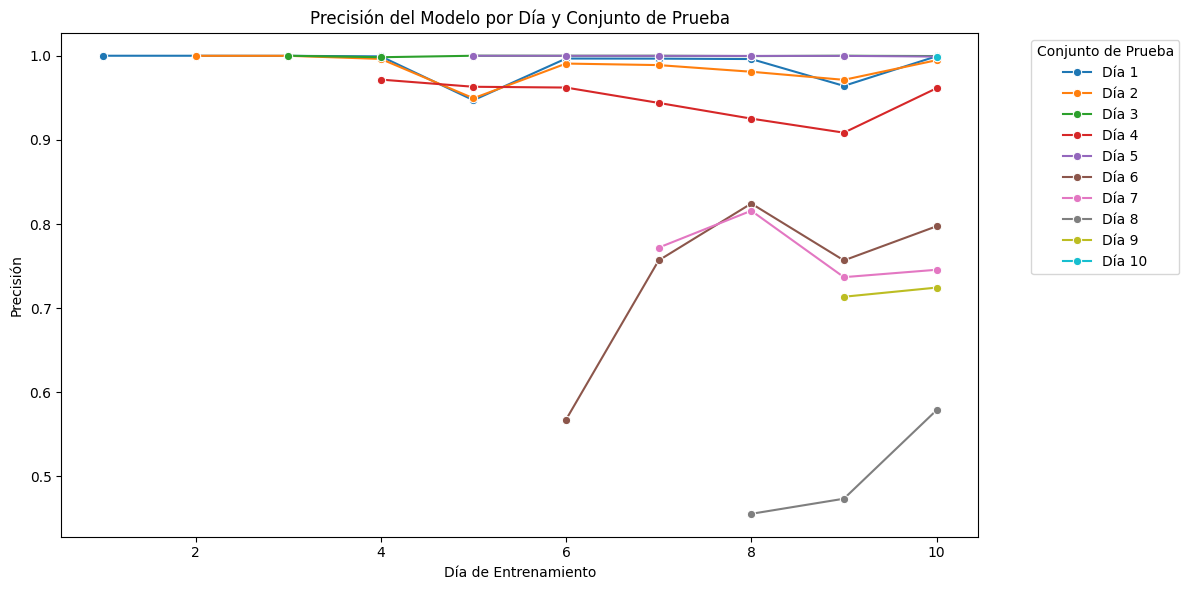

In [ ]:
# Visualizamos los resultados con un gráfico que muestra la precisión por conjunto de orueba y día:
plt.figure(figsize=(12, 6))
sns.lineplot(data=evaluation_results_df, x='Día', y='Precisión', hue='Conjunto de Prueba', marker='o')
plt.title('Precisión del Modelo por Día y Conjunto de Prueba')
plt.xlabel('Día de Entrenamiento')
plt.ylabel('Precisión')
plt.legend(title='Conjunto de Prueba', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

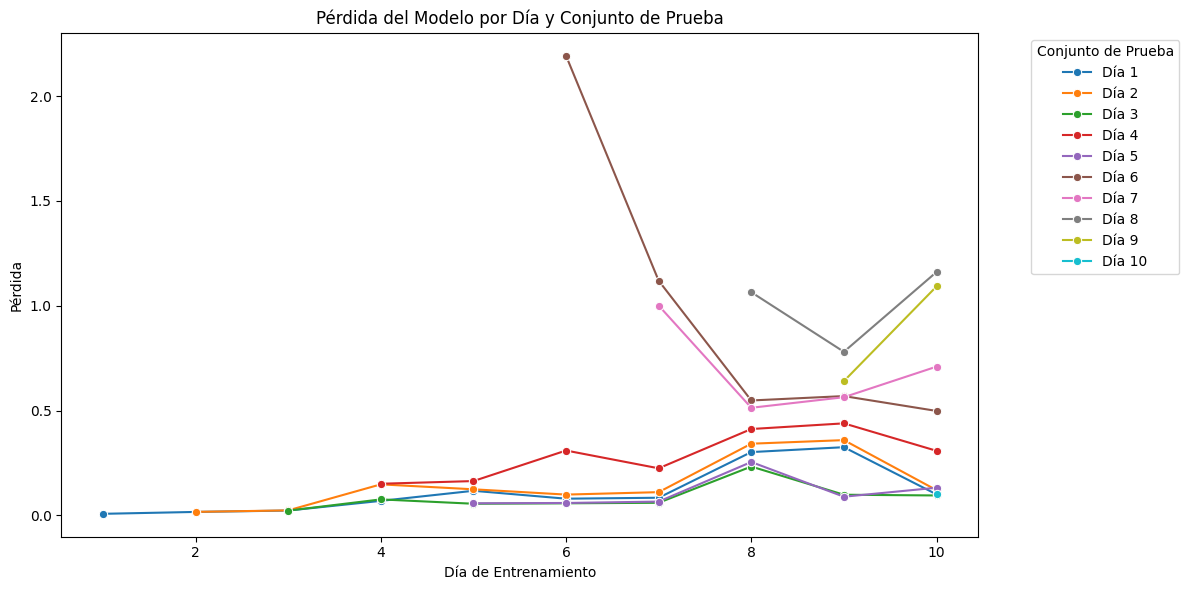

In [ ]:
# Hacemos lo propio para crear un gráfico de pérdida por conjunto de prueba y día:
plt.figure(figsize=(12, 6))
sns.lineplot(data=evaluation_results_df, x='Día', y='Pérdida', hue='Conjunto de Prueba', marker='o')
plt.title('Pérdida del Modelo por Día y Conjunto de Prueba')
plt.xlabel('Día de Entrenamiento')
plt.ylabel('Pérdida')
plt.legend(title='Conjunto de Prueba', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

El modelo incremental demuestra una buena capacidad de retención del conocimiento histórico gracias al uso del buffer de memoria y la destilación de conocimiento, manteniendo un rendimiento muy alto en los primeros días de entrenamiento, con precisión, exactitud y recall cercanos al 100%.

Durante los tres primeros días, el modelo logra adaptarse eficientemente a los nuevos datos sin degradar el rendimiento en los conjuntos anteriores, pero a partir del día 4, comienza a observarse una ligera pérdida en la precisión, especialmente en los conjuntos de prueba más recientes, lo que sugiere la creciente dificultad del modelo para equilibrar el aprendizaje de nueva información con la preservación de patrones antiguos. Este hecho podrñia darse debido a nuevos patrones de ataque difíciles de clasificar o que podrían tener similitudes con comportamientos benignos.

En los días 6 y 8, se produce una caída crítica en el rendimiento debido a la escasez de datos y a patrones más complejos, con precisiones por debajo del 60%. A pesar de estas fluctuaciones, el modelo mantiene un desempeño aceptable en conjuntos históricos, lo que confirma la eficacia de las técnicas aplicadas para evitar el olvido catastrófico.

Finalmente, durante el último día, el modelo logra una recuperación notable con una precisión cercana al 99% en el conjunto actual, aunque los dos días anteriores todavía muestran rendimientos inferiores. Esto podría deberse al tipo de ataque, que se corresponde a una infiltración y que puede realizar acciones posiblemente muy similares a comportamientos benignos.

En conclusión, el modelo incremental ofrece un buen equilibrio entre retención y adaptabilidad, pero sigue siendo sensible a ciertos datos o patrones, lo que sugiere la necesidad de técnicas adicionales como data augmentation o ajustes en los parámetros del buffer para mejorar su estabilidad y generalización.

## Paso 10: Evaluación final del modelo respecto a el conjunto de datos completo

In [ ]:
# Cargamos el modelo final (último modelo guardado):
final_day = len(train_files) - 1
final_model_path = os.path.join(save_dir, f'best_model_day_{final_day}.keras')
final_model = tf.keras.models.load_model(final_model_path, compile=True)

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 48 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
# Creamos un diccionario con todos los ficheros de prueba:
test_files = {
    '02-14-2018': pd.read_csv('/content/drive/My Drive/TFM - DS/output_datasets/02-14-2018_test.csv'),
    '02-15-2018': pd.read_csv('/content/drive/My Drive/TFM - DS/output_datasets/02-15-2018_test.csv'),
    '02-16-2018': pd.read_csv('/content/drive/My Drive/TFM - DS/output_datasets/02-16-2018_test.csv'),
    '02-20-2018': pd.read_csv('/content/drive/My Drive/TFM - DS/output_datasets/02-20-2018_test.csv'),
    '02-21-2018': pd.read_csv('/content/drive/My Drive/TFM - DS/output_datasets/02-21-2018_test.csv'),
    '02-22-2018': pd.read_csv('/content/drive/My Drive/TFM - DS/output_datasets/02-22-2018_test.csv'),
    '02-23-2018': pd.read_csv('/content/drive/My Drive/TFM - DS/output_datasets/02-23-2018_test.csv'),
    '02-28-2018': pd.read_csv('/content/drive/My Drive/TFM - DS/output_datasets/02-28-2018_test.csv'),
    '03-01-2018': pd.read_csv('/content/drive/My Drive/TFM - DS/output_datasets/03-01-2018_test.csv'),
    '03-02-2018': pd.read_csv('/content/drive/My Drive/TFM - DS/output_datasets/03-02-2018_test.csv')
}

In [ ]:
# Usaremos las etiquetas de nuestro codificador:
all_classes = list(label_encoder.classes_)
n_classes = len(all_classes)

# Procesamos los ficheros de test:
test_results_final = {}

for file_name, df in test_files.items():
    print(f"Procesando fichero {file_name} con el modelo final...")

    # Separamos las variables/características (X) y las etiquetas (y):
    X_test = df.drop(columns=["Label"]).values
    y_test = df["Label"].values

    # Escalamos las características con el scaler ya entrenado al inicio del notebook:
    X_test_scaled = scaler.transform(X_test)

    # Añadimos una dimensión extra para que sea compatible con las capas Conv1D:
    X_test_reshaped = X_test_scaled[..., np.newaxis]

    # Realizamos las predicciones:
    y_pred_proba = final_model.predict(X_test_reshaped)
    y_pred = np.argmax(y_pred_proba, axis=1)

    # Codificamos las etiquetas reales como binarias:
    y_test_encoded = label_encoder.transform(y_test)
    y_test_encoded_onehot = to_categorical(y_test_encoded, num_classes=2)

    # Generamos la matriz de confusión y las métricas del informe de clasificación:
    conf_matrix = confusion_matrix(y_test_encoded, y_pred, labels=[0, 1])
    report = classification_report(
        y_test_encoded,
        y_pred,
        target_names=all_classes,
        labels=[0, 1],
        output_dict=True,
        zero_division=0
    )

    # Calculamos los falsos positivos (FP) y los falsos negativos (FN) respecto a la propia clase:
    false_positives_by_class = {}
    false_negatives_by_class = {}

    for i, class_name in enumerate(all_classes):
        # Falsos Positivos (FP):
        fp = conf_matrix[:, i].sum() - conf_matrix[i, i]

        # Falsos Negativos (FN):
        fn = conf_matrix[i, :].sum() - conf_matrix[i, i]

        # Calculamos el porcentaje:
        total_predicted_for_class = conf_matrix[:, i].sum()
        total_actual_for_class = conf_matrix[i, :].sum()

        fp_percentage = (fp / total_predicted_for_class) * 100 if total_predicted_for_class > 0 else 0
        fn_percentage = (fn / total_actual_for_class) * 100 if total_actual_for_class > 0 else 0

        # Guardamos los resultados:
        false_positives_by_class[class_name] = (fp, fp_percentage)
        false_negatives_by_class[class_name] = (fn, fn_percentage)

    # Almacenamos los resultados obtenidos para el fichero de test actual:
    test_results_final[file_name] = {
        "conf_matrix": conf_matrix,
        "classification_report": pd.DataFrame(report).transpose(),
        "y_test_encoded": y_test_encoded,
        "y_pred": y_pred,
        "false_positives": false_positives_by_class,
        "false_negatives": false_negatives_by_class
    }

    # Mostramos un resumen de los resultados:
    print(f"Resultados para {file_name}:")
    print(f"Matriz de confusión:\n{conf_matrix}\n")
    print(f"Informe de clasificación:\n{pd.DataFrame(report).transpose()}\n")
    print("Falsos Positivos por clase (respecto a la clase):")
    for class_name, (fp, fp_percentage) in false_positives_by_class.items():
        print(f"{class_name}: {fp} ({fp_percentage:.2f}%)")
    print("\nFalsos Negativos por clase (respecto a la clase):")
    for class_name, (fn, fn_percentage) in false_negatives_by_class.items():
        print(f"{class_name}: {fn} ({fn_percentage:.2f}%)")
    print("\n" + "="*50 + "\n")

Procesando fichero 02-14-2018 con el modelo final...
2381/2381 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step
Resultados para 02-14-2018:
Matriz de confusión:
[[35481  2614]
 [    0 38095]]

Informe de clasificación:
              precision    recall  f1-score       support
Benign         1.000000  0.931382  0.964472  38095.000000
Malicious      0.935788  1.000000  0.966829  38095.000000
accuracy       0.965691  0.965691  0.965691      0.965691
macro avg      0.967894  0.965691  0.965651  76190.000000
weighted avg   0.967894  0.965691  0.965651  76190.000000

Falsos Positivos por clase (respecto a la clase):
Benign: 0 (0.00%)
Malicious: 2614 (6.42%)

Falsos Negativos por clase (respecto a la clase):
Benign: 2614 (6.86%)
Malicious: 0 (0.00%)


Procesando fichero 02-15-2018 con el modelo final...
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Resultados para 02-15-2018:
Matriz de confusión:
[[4949  301]
 [   0 5250]]

Informe de clasificación:
              precision    recall  f1-score       support
Benign

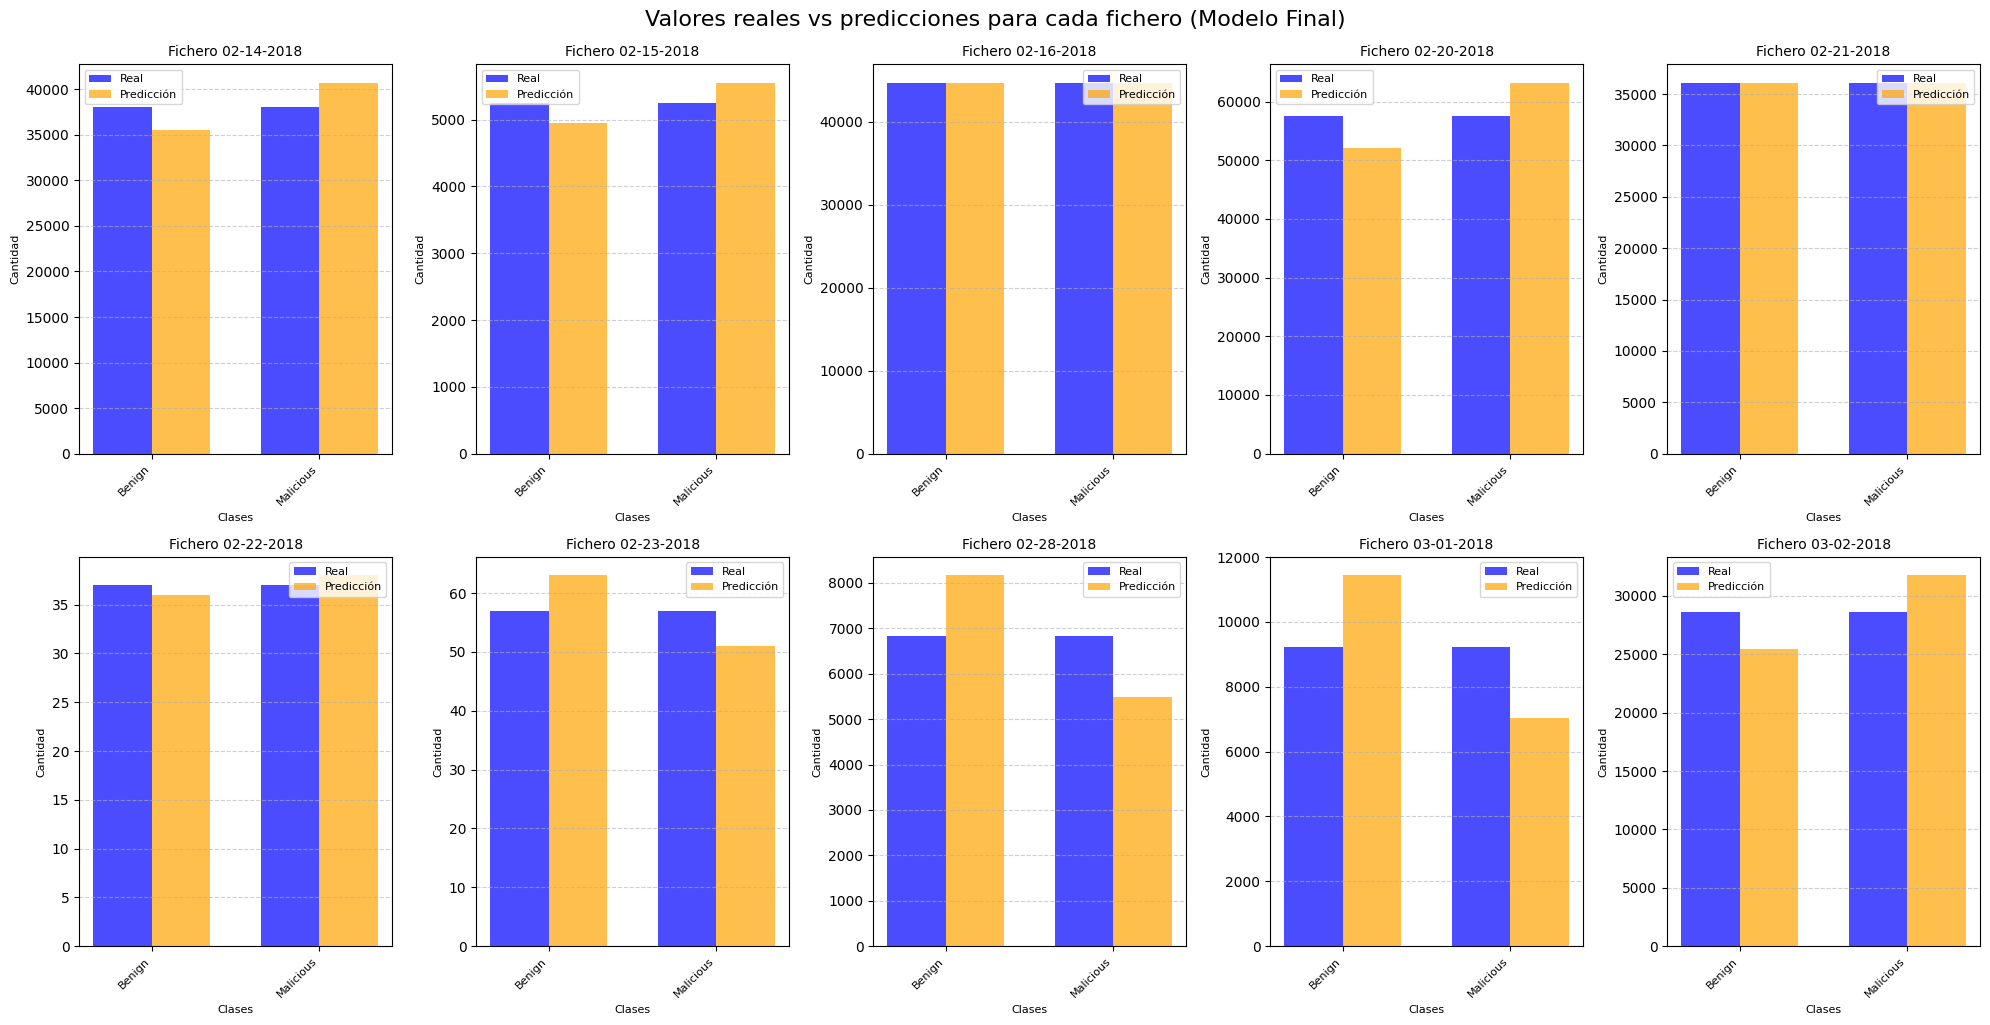

In [ ]:
# Creamos una figura con subplots para contener un gráfico comparativo entre valores reales versus predicciones:
fig, axes = plt.subplots(2, 5, figsize=(20, 10))
axes = axes.ravel()

# Graficamos los valores esperados vs predichos por cada fichero de test:
for idx, (file_name, results) in enumerate(test_results_final.items()):
    y_test_encoded = results["y_test_encoded"]
    y_pred = results["y_pred"]

    # Realizamos el conteo de ocurrencias por cada clase:
    real_counts = np.bincount(y_test_encoded, minlength=n_classes)
    predicted_counts = np.bincount(y_pred, minlength=n_classes)

    # Creamos el gráfico en el subplot correspondiente:
    ax = axes[idx]
    x = np.arange(n_classes)
    width = 0.35

    ax.bar(x - width/2, real_counts, width, label="Real", color="blue", alpha=0.7)
    ax.bar(x + width/2, predicted_counts, width, label="Predicción", color="orange", alpha=0.7)

    # Añadimos las etiquetas y leyenda:
    ax.set_title(f"Fichero {file_name}", fontsize=10)
    ax.set_xticks(x)
    ax.set_xticklabels(all_classes, rotation=45, ha="right", fontsize=8)
    ax.set_xlabel("Clases", fontsize=8)
    ax.set_ylabel("Cantidad", fontsize=8)
    ax.legend(fontsize=8)
    ax.grid(axis='y', linestyle='--', alpha=0.6)

# Mostramos la figura resultante:
plt.tight_layout()
plt.suptitle("Valores reales vs predicciones para cada fichero (Modelo Final)", fontsize=16, y=1.02)
plt.show()

El modelo incremental muestra un rendimiento sólido en los primeros días (02-14-2018 a 02-21-2018), logrando que las predicciones se alineen de buena forma con los valores reales en ambas clases. Esto evidencia su capacidad para retener información histórica y aplicar correctamente el conocimiento adquirido en el entrenamiento inicial. La precisión y el recall en estos días son notablemente altos, lo que refuerza la eficacia de las técnicas aplicadas para evitar el olvido catastrófico.

No obstante, en los días posteriores (02-22-2018 en adelante), especialmente cuando la cantidad de datos es limitada o los patrones son más difíciles de diferenciar respecto a acciones benignas, el modelo muestra errores más pronunciados.

Se observan problemas como la existencia de una cantidad considerable de falsos negativos de la clase "Malicious", lo que puede resultar crítico en entornos como el quesimulamos en este TFM. Esto indica que, aunque el modelo es capaz de adaptarse dinámicamente, su rendimiento puede verse afectado cuando enfrenta datos más complejos o desbalanceados, lo que sugiere la necesidad de optimizar y mejorar el modelo para mejorar su generalización en escenarios desafiantes.